In [14]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Plots
using CSV
import OrderedCollections: OrderedDict
using StatsBase
import Term: tprintln
import HypothesisTests: EqualVarianceTTest, pvalue
using MultipleTesting

using MyterialColors
import MyterialColors: blue, red

# import Pkg
# Pkg.add(url="https://github.com/JuliaPlots/VennEuler.jl.git")
using VennEuler

colors = OrderedDict(
    "complete" => "black",
    "missing_s" => teal_dark,
    "missing_curv_5cm" => teal,
    "missing_curv_15cm" => teal,
    "missing_curv_25cm" => teal,
    "missing_curv_class" =>  teal_light,
    "missing_domega_1000ms" => indigo_dark,
    "missing_domega_500ms" => indigo_dark,
    "missing_domega_250ms" => indigo_dark,
    "missing_omega" => blue,
    "missing_Δomega_class" => indigo_darker,
    "missing_omega_squared" => blue,
    "missing_omega_class" => blue_light,
    "missing_dv_1000ms" => pink_dark,
    "missing_dv_500ms" => pink_dark,
    "missing_dv_250ms" => pink_dark,
    "missing_v" => pink,
    "missing_v_squared" => pink,
    "missing_speed_class" => salmon_dark,
    "missing_Δspeed_class" => red,

)


include(raw"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\glm\glm_utils.jl");

## Load GLM results
Load metadata of which cells were ran and their correlations

In [2]:
fitted = filter(kv -> kv.second["glm_fitted"], metadata)
@info "Fitted $(length(fitted))/$(length(metadata)) units"

formulas = generate_formulas()

for (k,v) in fitted
    # get the pearson correlations
    v["correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "correlations.csv")
    ))

    # get the correlations of the shuffled data
    v["shuffled_correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "shuffled_correlations.csv")
    ))

    # get a `FittedModel`
    try
        v["model"] = load_fitted(v, "complete", formulas)
    catch
        v["model"] = nothing
    end
end

nomodel = filter(kv -> isnothing(kv.second["model"]), fitted) |> keys |> collect
length(nomodel) > 0 && @info "No model fitted for $(length(nomodel)) units - revise metadata";

@Info (Main):  Fitted 401/401 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 20 Jun 2022 15:58:16 


## Identify tuned
Look for units whose pearson correlation in the full mode is above the 99th CI of the shuffled correlations

In [3]:
to_ignore = []
for (k, unit) in fitted
    cbest = mean(unit["correlations"][:, "complete"])
    cshuff = max.(eachcol(unit["shuffled_correlations"])...)

    threshold = 0.0
    try
        threshold = percentile(cshuff, 99.9) 
    catch
        @info "nans in correlation"
        push!(to_ignore, k)
        continue
    end

    unit["correlation_threshold"]  = threshold
    unit["tuned"] = cbest > threshold
end

@info "something went wrong for $(length(to_ignore)) units" 

tuned = filter(kv -> kv.first ∉ to_ignore, fitted)
tuned = filter(kv -> kv.second["tuned"], tuned)
tuned = OrderedDict(sort(collect(tuned), by = kv->kv.second["best_corr"]))
@info "Tuned $(length(tuned))/$(length(fitted)) units"

@Info (Main):  something went wrong for 0 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 20 Jun 2022 15:58:40 
@Info (Main):  Tuned 208/401 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 20 Jun 2022 15:58:40 


plot a single tuned unit

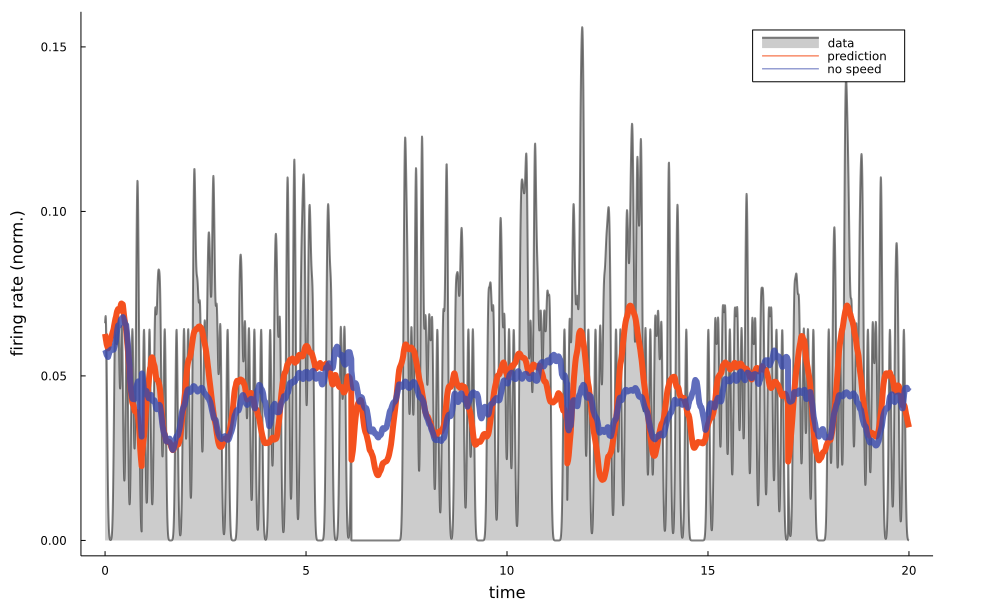

In [42]:
unit = collect(values(tuned))[end - 21]
unit_data = load_data(unit)

nov_model = load_fitted(unit, "missing_speed_class")
ŷ_nov = predict(nov_model, unit_data)

# nov_model = load_fitted(unit, "missing_omega_class")
# ŷ_nov = predict(nov_model, unit_data)

x = load_data(unit["model"])
ŷ = predict(unit["model"], x)
y = x.p_spike

t0 = 30_001
t1 = t0 + 4_000

time = collect(0:(t1-t0)) / 200  # time in seconds

plot(ylabel="firing rate (norm.)", xlabel="time", size=(1000, 600), grid=false,
left_margin = 5Plots.mm, right_margin = 15Plots.mm,
)
plot!(time,  y[t0:t1], fillrange =0, fillcolor=:black, fillalpha=.2, color="black", lebel="data", alpha=.5, lw=2, label="data")
plot!(time,  ŷ[t0:t1], lw=6, label="prediction", color=salmon_dark)
plot!(time,  ŷ_nov[t0:t1], lw=6, alpha=.8, label="no speed", color=indigo_dark)




## Variables tuning

Start by plotting for a unit the pearson correlation of each model and compare it to the full model.

D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\FC_220415_BAA1101192_hairpin_unit_548


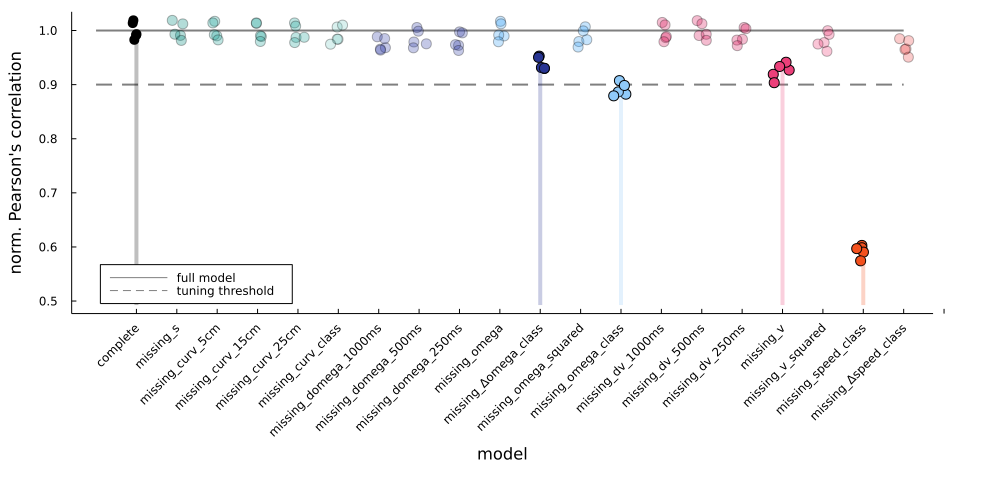

In [41]:


unit = collect(values(tuned))[end - 21]
println(unit["folder"])

mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
tuning_th = .9 # * mean_corr["complete"]
complete_model_corr = mean_corr["complete"]
corrs = OrderedDict(k => v ./ complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

# get pvalues betweeen all models correlations and complete
filtered_keys = filter!(k -> k != "complete", collect(keys(corrs)))
pvals = map(
    k -> pvalue(
        EqualVarianceTTest(
            values(corrs[k]),
            values(corrs["complete"])
        )
    ),
    filtered_keys
)
pvals = Dict( k => p for (k, p) in zip(filtered_keys, adjust(pvals, Bonferroni())))





# plot
plot()
plot!([0, length(mean_corr)], [1, 1], color="black", alpha=.5, lw=2, label="full model")
plot!([0, length(mean_corr)], [tuning_th, tuning_th], color="black", linestyle=:dash, alpha=.5, lw=2, label="tuning threshold")

for (i, model) in enumerate(keys(colors))
    corr = mean_corr[model] / complete_model_corr
    # istuned = corr <= tuning_th
    istuned = model == "complete" ? true : pvals[model] <= 0.05

    # istuned && scatter!([i], [corr], color="black", alpha=1, ms=12, label=nothing)
    # scatter!([i], [corr], color=colors[model], alpha=1, ms=8, label=nothing)
    scatter!(ones(5)*i .+ 0.1randn(5), corrs[model], color=colors[model], ms=6, alpha= istuned ? 1 : .3, label=nothing)
    istuned && plot!(
        [i, i],
        [min(values(mean_corr)...) / complete_model_corr - .1, corr],
        color=colors[model],
        alpha=.25,
        lw=4,
        label=nothing
    )
end

plot!(   
    xticks = (
        1:length(mean_corr)+1,
        keys(colors)
    ), 
    xrotation = 45,
    ylabel = "norm. Pearson's correlation",
    xlabel = "model",
    grid=false,
    size=(1000, 500),
    left_margin = 5Plots.mm, right_margin = 15Plots.mm,
    bottom_margin = 25Plots.mm,
    legend=:bottomleft
    )


# FC_220414_BAA1101192_hairpin_unit_372
# FC_220415_BAA1101192_hairpin_unit_548

Get all tuning for all units

In [43]:
variables_tuning = Dict{String, Vector{Bool}}(k => [] for k in keys(colors))

for (name, unit) in tuned
    # get mean pearson correlation of each model and threshold
    mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
    complete_model_corr = mean_corr["complete"]
    corrs = OrderedDict(k => v ./ complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

    # get pvalues with bonferroni
    filtered_keys = filter!(k -> k != "complete", collect(keys(corrs)))
    pvals = map(
        k -> pvalue(
            EqualVarianceTTest(
                values(corrs[k]),
                values(corrs["complete"])
            )
        ),
        filtered_keys
    )
    pvals = Dict( k => p for (k, p) in zip(filtered_keys, adjust(pvals, Bonferroni())))
    
    # get which models are tuned
    for model in keys(colors)    
        # corr, pval = mean_corr[model], pvals[model]
        vtuned = model == "complete" ? true : pvals[model] <= 0.05
        push!(variables_tuning[model],  vtuned)
    end
end

variables_tuning = DataFrame(variables_tuning);

In [44]:
ntuned_var = Dict(k=>sum(variables_tuning[:, k]) for k in keys(colors))
var_classes = ["missing_curv_class", "missing_omega_class", "missing_speed_class", "missing_Δspeed_class", "missing_Δomega_class"]
classes_names = ["Position/curvature class", "angular velocity class", "speed class", "future speed class", "future angular velocity class"]

# get percentage of units tuned to each class of variables
for (n, var) in zip(classes_names, var_classes)
    # print number of units tuned to class vs total
    ntuned = ntuned_var[var]
    ntotal = length(tuned)
    tprintln("{green}$(ntuned){/green}/$(ntotal) ($(round(ntuned/ntotal * 100; digits=2))%) units tuned to {bold white}$(n){/bold white}";)
end

36/208 (17.31%) units tuned to Position/curvature class 
83/208 (39.9%) units tuned to angular velocity class 
199/208 (95.67%) units tuned to speed class 
90/208 (43.27%) units tuned to future speed class 
8/208 (3.85%) units tuned to future angular velocity class 


get how many units are tuned to > 1 class of variables

In [45]:
# get which units are tuned to more than one class
n_variablesclass_per_unit = Dict{Any, Any}(
    i => 0 for i in 1:5
)
# n_variablesclass_per_unit["tot"] = 0

for unit in eachrow(variables_tuning)
    nvars = sum(values(unit[var_classes]))
    nvars > 0 && (n_variablesclass_per_unit[nvars] += 1)
    # nvars > 0 && (n_variablesclass_per_unit["tot"] += 1)
end
n_variablesclass_per_unit

╭──── Dict {Any, Any}  ────────────────╮
│                                      │
│     {Int64} │ 5 => 2  │ {Int64}      │
│     {Int64} │ 4 => 8  │ {Int64}      │
│     {Int64} │ 2 => 70 │ {Int64}      │
│     {Int64} │ 3 => 54 │ {Int64}      │
│     {Int64} │ 1 => 72 │ {Int64}      │
│                                      │
╰────────────────────────── 5 items ───╯


In [9]:
# using VennEuler

# x = Matrix(values(variables_tuning[:, var_classes]))

# classes = map(
#     c -> split(c, "_")[2], var_classes
# )
# eo = make_euler_object(classes, x, EulerSpec(:circle), sizesum=0.5)
# loss, state, result = optimize(eo, random_state(eo))

# render("three-circles.svg", eo, state)

D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\FC_220414_BAA1101192_hairpin_unit_372


Get how many units are tuned to `speed`, `omega` and spatial info.

In [46]:
import OrderedCollections: OrderedDict
import Term: Table, Panel, hLine, cvstack
import Term: highlight

N = size(variables_tuning, 1)
count_perc(x) = highlight("$(x)/$(N) ($(round(x/N * 100; digits=2))%)")

tb(x) = Table(
    x;
    header_style="bold white on_black",
    box=:NONE, style="blue"
)

classes = ["missing_v", "missing_v_squared", "missing_dv_250ms", "missing_dv_500ms", "missing_dv_1000ms", "missing_Δspeed_class"]
cnames = ["speed", "speed²", "Δv 250ms", "Δv 500ms", "Δv 1000ms", "Δspeed"]


V = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["missing_omega", "missing_omega_squared", "missing_domega_250ms", "missing_domega_500ms", "missing_domega_1000ms", "missing_Δomega_class"]
cnames = ["ang. velocity","ω²", "Δω 250ms", "Δω 500ms", "Δω 1000ms", "Δω"]

O = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["missing_s", "missing_curv_5cm", "missing_curv_15cm", "missing_curv_25cm"]
cnames = ["arena location", "curvature at 10 cm", "curvature at 20 cm", "curvature at 30 cm"]

K = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


Panel(
    cvstack(Panel(V; fit=false, width=150, title="SPEED", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(170; box=:HEAVY), "",
    Panel(O; fit=false, width=150, title="ANGULAR VELOCITY", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(170; box=:HEAVY), "",
    Panel(K; fit=false, width=150, title="POSITION", title_style="bold red", title_justify=:center, justify=:center, box=:NONE));
    fit=false, width=180, justify=:center
)

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                       SPEED                                                                                      │
│                                                                                                                                                                                  │
│                                      speed              speed²             Δv 250ms           Δv 500ms         Δv 1000ms           Δspeed                                        │
│                                                                                                                                                                                  │
│                                  83/208 (39.9%)     38/208 (18.27%)     24/208 (11.54%)     2

Get how many units are tuned to speed/ang vel now, in the future or both

In [47]:
speed_tuned = variables_tuning[:, "missing_v"] .|| variables_tuning[:, "missing_v_squared"]
Δspeed_tuned = variables_tuning[:, "missing_dv_250ms"] .|| variables_tuning[:, "missing_dv_500ms"] .|| variables_tuning[:, "missing_dv_1000ms"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :speed=> count_perc(sum(speed_tuned)),
    :Δspeed=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ─────────────────────────╮
│                                                     │
│   {Symbol} │  both  => 17/208 (8.17%)  │ {String}   │
│   {Symbol} │ Δspeed => 31/208 (14.9%)  │ {String}   │
│   {Symbol} │ speed  => 86/208 (41.35%) │ {String}   │
│                                                     │
╰───────────────────────────────────────── 3 items ───╯


In [48]:
speed_tuned = variables_tuning[:, "missing_omega"] .|| variables_tuning[:, "missing_omega_squared"]
Δspeed_tuned = variables_tuning[:, "missing_domega_250ms"] .|| variables_tuning[:, "missing_domega_500ms"] .|| variables_tuning[:, "missing_domega_1000ms"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :ω=> count_perc(sum(speed_tuned)),
    :Δω=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ───────────────────────╮
│                                                   │
│   {Symbol} │ both =>  1/208 (0.48%)  │ {String}   │
│   {Symbol} │  Δω  =>  1/208 (0.48%)  │ {String}   │
│   {Symbol} │  ω   => 54/208 (25.96%) │ {String}   │
│                                                   │
╰─────────────────────────────────────── 3 items ───╯


In [49]:
curv_tuning = variables_tuning[:, "missing_curv_5cm"] .|| variables_tuning[:, "missing_curv_15cm"] .|| variables_tuning[:, "missing_curv_25cm"]
s_tuning = variables_tuning[:, "missing_s"]
both_tuned = curv_tuning .&& s_tuning

Dict(
    :curvature=> count_perc(sum(curv_tuning)),
    :position=> count_perc(sum(s_tuning)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ───────────────────────────╮
│                                                       │
│   {Symbol} │   both    => 7/208 (3.37%)  │ {String}   │
│   {Symbol} │ curvature => 15/208 (7.21%) │ {String}   │
│   {Symbol} │ position  => 26/208 (12.5%) │ {String}   │
│                                                       │
╰─────────────────────────────────────────── 3 items ───╯
